## Importing Libraries

In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
# !pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
import numpy as np

# !pip3 install graphviz
# !pip3 install hiddenlayer
import hiddenlayer as hl

## Setting the seed

In [2]:
torch.manual_seed(10)

## Downloading MNIST Train/Test Data and preparing Train/Test Dataloaders


In [3]:
batch_size = 64
use_cuda = torch.cuda.is_available()

data_loader_args = {'num_workers': 2, 'pin_memory': True, 'batch_size': batch_size, 'shuffle': True} if use_cuda else {'batch_size': 32, 'shuffle': True}
train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation(5), # data augmentation
                        transforms.RandomAffine(degrees=5, translate=(0.15,0.15), scale=(0.9, 1.1)), # data augmentation
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
train_loader = torch.utils.data.DataLoader(train, **data_loader_args)
test_loader = torch.utils.data.DataLoader(test, **data_loader_args)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Visualising the data

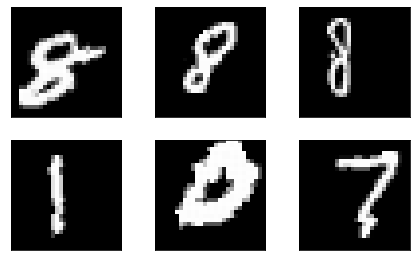

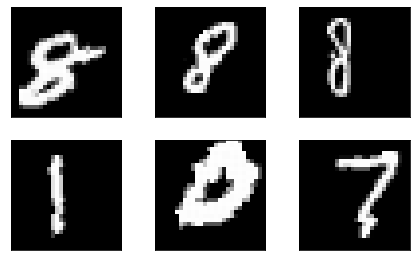

In [4]:
images, labels, = next(iter(train_loader))

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
fig

## Defining Neural Network


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)  # 28x28x1 -> 28x28x4
        self.bn1 = nn.BatchNorm2d(num_features=4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)  # 28x28x4 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(num_features=8)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1)  # 28x28x8 -> 28x28x12
        self.bn3 = nn.BatchNorm2d(num_features=12)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1)  # 28x28x12 -> 28x28x16
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, padding=1)  # 28x28x16 -> 28x28x20
        self.bn5 = nn.BatchNorm2d(num_features=20)
        self.dropout = nn.Dropout2d(0.1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28x20 -> 14x14x20
        self.transition1 = nn.Conv2d(in_channels=20, out_channels=4, kernel_size=1)  # 14x14x20 -> 14x14x4
        
        self.conv6 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)  # 14x14x4 -> 12x12x8
        self.bn6 = nn.BatchNorm2d(num_features=8)
        self.conv7 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3)  # 12x12x8 -> 10x10x12
        self.bn7 = nn.BatchNorm2d(num_features=12)
        self.conv8 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3)  # 10x10x12 -> 8x8x16
        self.bn8 = nn.BatchNorm2d(num_features=16)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1) # 8x8x16 -> 8x8x10
        
        self.gap = nn.AvgPool2d(kernel_size=8)
        self.fc1 = nn.Linear(in_features=10, out_features=10) 

    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.transition1(self.pool1(x))
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.bn7(F.relu(self.conv7(x)))
        x = self.conv9(self.bn8(F.relu(self.conv8(x))))
        x = self.gap(x)
        x = x.view(-1,10)
        x = self.fc1(x)

        return F.log_softmax(x, dim=1)

## Checking for GPU

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## Defining Train/Test Function

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    # set the model in training model
    model.train()
    correct = 0
    epoch_loss = 0

    pbar = tqdm(train_loader)
    # run for all the data in train_loader
    for batch_idx, (data, target) in enumerate(pbar):
        # move the data to device
        data, target = data.to(device), target.to(device)

        # zero out the gradients
        optimizer.zero_grad()

        # forward pass the model with the data
        output = model(data)

        # compute the loss occured
        loss = F.nll_loss(output, target)

        epoch_loss += loss.item()

        # compute the backward gradients
        loss.backward()

        # update the optimizer params
        optimizer.step()
    
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        
        # get the index of max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        
        # increment the correct prediction count if pred is correct
        correct += pred.eq(target.view_as(pred)).sum().item()
    
    # train loss divided by the total number of items in train dataset
    train_loss = epoch_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    print(f'Train set: Average loss: {train_loss:.3f}', 
          f'Accuracy: {accuracy}')
    
    return train_loss


def test(model, device, test_loader):
    
    # set the model in evaluation model
    model.eval()

    # set the loss to zero
    test_loss = 0
    
    # the number of correct classifications
    correct = 0

    # turn off gradients during the testing
    with torch.no_grad():
        for (data, target) in test_loader:

            # move the data to device
            data, target = data.to(device), target.to(device)

            # forward pass the model and get the output
            output = model(data)

            # accumulate the loss from both the network outputs
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # get the index of max log-probability
            pred = output.argmax(dim=1, keepdim=True)

            # increment the correct prediction count if pred is correct
            correct += pred.eq(target.view_as(pred)).sum().item()


    # test loss divided by the total number of items in test dataset
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.3f}', 
          f'Accuracy: {accuracy}')
    return test_loss


## Move the model to the specified device

In [8]:
model = NeuralNetwork().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
         Dropout2d-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             296
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
            Conv2d-7           [-1, 16, 28, 28]           1,744
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 20, 28, 28]           2,900
      BatchNorm2d-10           [-1, 20, 28, 28]              40
        MaxPool2d-11           [-1, 20, 14, 14]               0
           Conv2d-12            [-1, 4, 14, 14]              84
           Conv2d-13            [-1, 8, 12, 12]             296
      BatchNorm2d-14            [-1, 8,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Training the model with Learning Rate Scheduler

In [9]:
# use Stochastic Gradient Descent as the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

# set the number of epochs to train for
num_epoch = 12

train_loss_values = []
valid_loss_values = []

# run it for epoch number of times
for epoch in range(1, num_epoch+1):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss = train(model, device, train_loader, optimizer, epoch)
    # test the model
    test_loss = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    valid_loss_values.append(test_loss)

    scheduler.step()


Epoch 1 : 


loss=0.3429986536502838 batch_id=937: 100%|██████████| 938/938 [00:41<00:00, 22.74it/s]

Train set: Average loss: 0.603 Accuracy: 80.05


Test set: Average loss: 0.071 Accuracy: 97.78

Epoch 2 : 


loss=0.03419129550457001 batch_id=937: 100%|██████████| 938/938 [00:41<00:00, 22.55it/s]

Train set: Average loss: 0.125 Accuracy: 96.44333333333333


Test set: Average loss: 0.059 Accuracy: 98.14

Epoch 3 : 


loss=0.16522426903247833 batch_id=937: 100%|██████████| 938/938 [00:42<00:00, 22.20it/s]

Train set: Average loss: 0.095 Accuracy: 97.17666666666666


Test set: Average loss: 0.050 Accuracy: 98.48

Epoch 4 : 


loss=0.0651002749800682 batch_id=937: 100%|██████████| 938/938 [00:42<00:00, 22.02it/s]

Train set: Average loss: 0.083 Accuracy: 97.5


Test set: Average loss: 0.035 Accuracy: 98.88

Epoch 5 : 


loss=0.03457719087600708 batch_id=937: 100%|██████████| 938/938 [00:42<00:00, 22.18it/s]

Train set: Average loss: 0.075 Accuracy: 97.78833333333333


Test set: Average loss: 0.031 Accuracy: 98.98

Epoch 6 : 


loss=0.0825406014919281 batch_id=937: 100%|██████████| 938/938 [00:42<00:00, 22.13it/s]

Train set: Average loss: 0.067 Accuracy: 97.945


Test set: Average loss: 0.028 Accuracy: 99.07

Epoch 7 : 


loss=0.03722963109612465 batch_id=937: 100%|██████████| 938/938 [00:42<00:00, 22.29it/s]

Train set: Average loss: 0.064 Accuracy: 98.055


Test set: Average loss: 0.029 Accuracy: 99.06

Epoch 8 : 


loss=0.03204820677638054 batch_id=937: 100%|██████████| 938/938 [00:41<00:00, 22.38it/s]

Train set: Average loss: 0.060 Accuracy: 98.14833333333333


Test set: Average loss: 0.031 Accuracy: 99.03

Epoch 9 : 


loss=0.029772572219371796 batch_id=937: 100%|██████████| 938/938 [00:42<00:00, 22.19it/s]

Train set: Average loss: 0.048 Accuracy: 98.53833333333333


Test set: Average loss: 0.020 Accuracy: 99.38

Epoch 10 : 


loss=0.009376359172165394 batch_id=937: 100%|██████████| 938/938 [00:41<00:00, 22.37it/s]

Train set: Average loss: 0.044 Accuracy: 98.64833333333333


Test set: Average loss: 0.019 Accuracy: 99.43

Epoch 11 : 


loss=0.058516353368759155 batch_id=937: 100%|██████████| 938/938 [00:42<00:00, 22.24it/s]

Train set: Average loss: 0.044 Accuracy: 98.57166666666667


Test set: Average loss: 0.020 Accuracy: 99.4

Epoch 12 : 


loss=0.008633488789200783 batch_id=937: 100%|██████████| 938/938 [00:42<00:00, 21.96it/s]

Train set: Average loss: 0.045 Accuracy: 98.63333333333334


Test set: Average loss: 0.019 Accuracy: 99.41


## Plotting the loss function

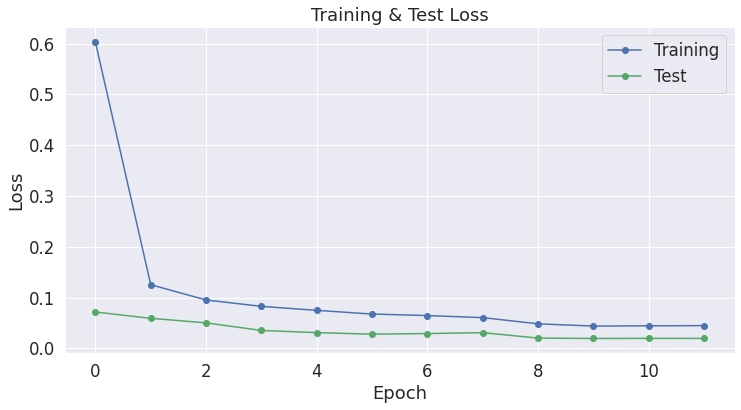

In [10]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(np.array(train_loss_values), 'b-o', label="Training")
plt.plot(np.array(valid_loss_values), 'g-o', label="Test")

# Label the plot.
plt.title("Training & Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:243: UserWarning: ONNX export failed on feature_dropout because training mode not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


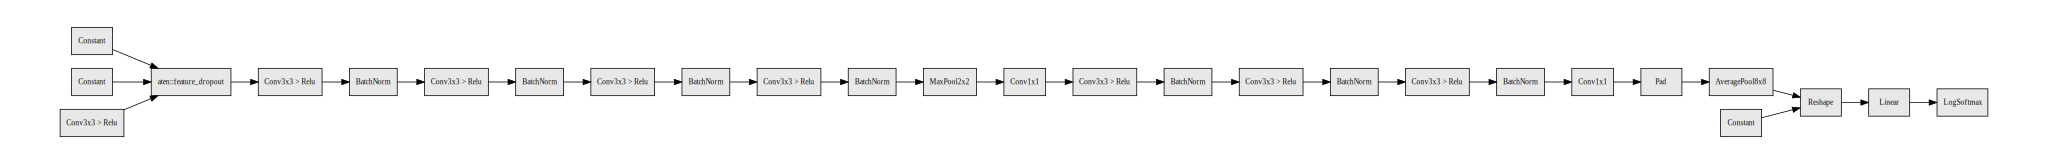

In [14]:
model = NeuralNetwork().to('cuda')
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/best_network", "png")
network_graph